In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import gc
import time

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns

from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
train_app = pd.read_pickle('after_reducion/train_app.pkl')
test_app = pd.read_pickle('after_reducion/test_app.pkl')

train_user = pd.read_pickle('after_reducion/train_user.pkl')
test_user = pd.read_pickle('after_reducion/test_user.pkl')

In [3]:
train_label = train_user[['phone_no_m','label']]

In [4]:
'''
    观察诈骗电话和app使用的关系
    因为缺失的大多数都是app名字和月份，所以不进行处理。(用unknown处理，或者用LGB直接对缺失值做处理)
    
    特征
        1. app使用量，平均值：
                        正常电话 >> 诈骗电话
                        (有些诈骗电话使用app数量很大，结合时间特征观察，看是不是后期才转化为诈骗电话)
                        不是那么简单，看看tableau结合时间做分析
        2. app为null，正常的比诈骗电话占比要多，难以作为特征
        
        3. 时间和busi_name,总体上差不多，诈骗电话相对用量较少，正常电话波动比较大
                波动主要是由于busi_name = NULL  引起的
                求累计波动：
                可以看到，根据每个月的app用量来累计，可以得到下图，
                    正常电话      vs      诈骗电话
            mean     193.160232           74.733435
                                            超过一半波动为0
            
        4. 正常电话用的流量会更多，无论是总体还是平均，在每一个月份，总体平均值高了13左右
            可能需要定义几个区间作为特征
            
            
        
    
'''

'\n    观察诈骗电话和app使用的关系\n    因为缺失的大多数都是app名字和月份，所以不进行处理。(用unknown处理，或者用LGB直接对缺失值做处理)\n    \n    特征\n        1. app使用量，平均值：\n                        正常电话 >> 诈骗电话\n                        (有些诈骗电话使用app数量很大，结合时间特征观察，看是不是后期才转化为诈骗电话)\n        2. app为null，正常的比诈骗电话占比要多，难以作为特征\n        \n        3. 时间和busi_name,总体上差不多，诈骗电话相对用量较少，正常电话波动比较大\n                波动主要是由于busi_name = NULL  引起的\n                求累计波动：\n                可以看到，根据每个月的app用量来累计，可以得到下图，\n                    正常电话      vs      诈骗电话\n            mean     193.160232           74.733435\n                                            超过一半波动为0\n            \n    \n'

In [5]:
a = pd.merge(train_app,train_label,on='phone_no_m',how='inner')
# 用tableau发现，为null时，label为0和为1的结果相差不大，
a.dropna(subset=['month_id'],inplace=True)

In [81]:
# b = 统计busi_name
b = a.groupby('phone_no_m').count().reset_index()[['phone_no_m','label']]
b.rename(columns={'label':'app_count'},inplace=True)
b = pd.merge(b,train_label,on='phone_no_m',how='inner')

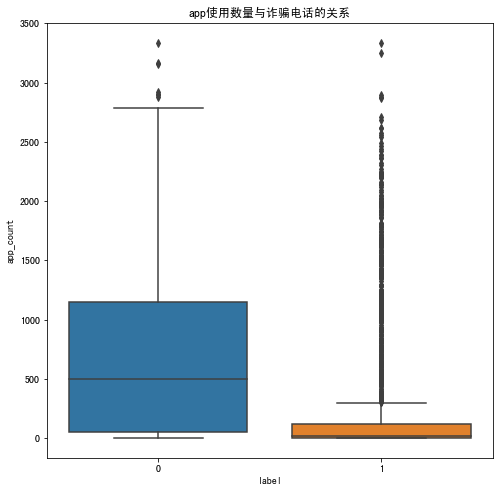

      app_count                                                          
          count        mean         std  min   25%    50%     75%     max
label                                                                    
0        4144.0  670.625965  655.931199  0.0  49.0  495.0  1149.0  3336.0
1        1962.0  256.735984  545.956876  0.0   0.0   17.0   119.0  3337.0


2608

In [82]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
sns.boxplot(y=b['app_count'],x=b['label'])
plt.title('app使用数量与诈骗电话的关系')
plt.show()

print(b.groupby('label').describe())
del b
gc.collect()

In [136]:
# 考虑每个号码的平均波动
groups = a.groupby(['phone_no_m','month_id']).count()

groups = pd.DataFrame(groups['label'].shift() - groups['label']).abs() # ----> diff()

# 把month_id去掉，然后根据phone_no_m做分组，求累加
groups = groups.reset_index().drop(columns='month_id').dropna().groupby('phone_no_m').sum().rename(columns={'label':'cumsum_app_use'}).reset_index()

groups = pd.merge(groups,train_label,on='phone_no_m',how='inner')

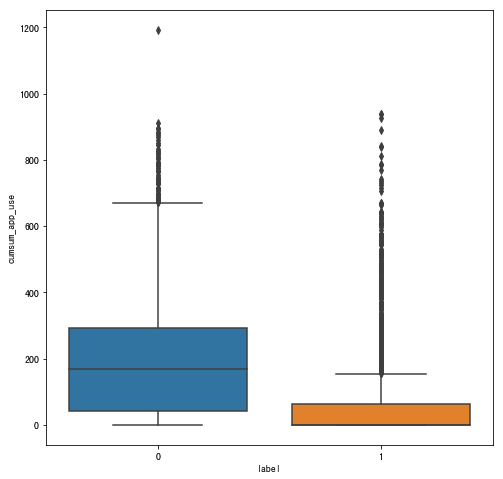

      cumsum_app_use                                                          
               count        mean         std  min   25%    50%     75%     max
label                                                                         
0             4144.0  193.160232  169.966983  0.0  41.0  169.0  293.00  1193.0
1             1962.0   74.733435  153.649700  0.0   0.0    0.0   62.75   940.0


5045

In [140]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.boxplot(y=groups['cumsum_app_use'],x=groups['label'])
plt.show()

print(groups.groupby('label').describe())

del groups
gc.collect()

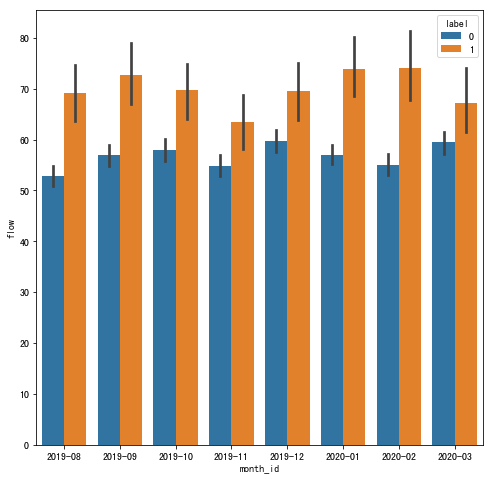

,flow
label,
0,56.728973
1,69.864731


In [16]:
# 观察flow
fig,ax=plt.subplots(1,1,figsize=(8,8))
sns.barplot(y=a['flow'],x=a['month_id'],hue=a['label'])
plt.show()

a.groupby('label').mean()

In [145]:
test_app.dropna(subset=['month_id'],inplace=True)
train_app.dropna(subset=['month_id'],inplace=True)

In [146]:
train_app.to_pickle('after_EDA/train_app.pkl')
test_app.to_pickle('after_EDA/test_app.pkl')

In [67]:
# 用tableau可视化
a.to_csv('app.csv')